In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm

In [6]:
transformations = transforms.Compose([transforms.ToTensor(), 
                        transforms.Lambda(lambda img: img.squeeze().reshape(784))])

trans_target = lambda label: F.one_hot(torch.tensor(label), num_classes=10)


train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transformations , target_transform=trans_target)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transformations , target_transform=trans_target)

%config Completer.use_jedi = False


The label for this image is: 5


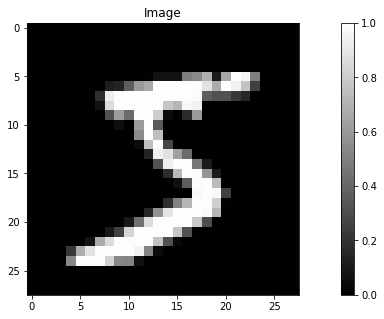

In [7]:
# Visualizing the images and lables
fig, ax = plt.subplots()
fig.set_size_inches(15,5)

img = train_dataset[0][0].numpy().reshape(28, 28)
im = ax.imshow(img, cmap=plt.cm.gray)
fig.colorbar(im)
ax.set_title("Image")
print(f"The label for this image is: {train_dataset[0][1].argmax()}")

In [8]:
#Dataloader 
batch_size = 20
train_loader = DataLoader(
                dataset= train_dataset,
                batch_size=batch_size,
                shuffle=False) 
test_loader = DataLoader(
                dataset = test_dataset,
                batch_size=batch_size,
                shuffle=True)


In [9]:
class NeuralNet():
    def __init__(self, LR, batch_size):
        np.random.seed(0)

        self.layer1 = np.random.uniform(-0.5, 0.5, (784, 64))
        self.layer2 = np.random.uniform(-0.5, 0.5, (64, 10))
#         self.bias1 = np.zeros((1, 64))
#         self.bias2 = np.zeros((1,10))
        self.batch_size = batch_size
        self.LR = LR
        
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def softmax(self, z):
        ez = np.exp(z/z.max())
        sum_ez = np.sum(ez, axis=0)
        return ez / (sum_ez)    
    
    def d_sigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def d_softmax(self, a, y):
        result = np.sum((a-y).T * (np.diag(a.squeeze()) - np.multiply(a, a.T)), axis=1)
        return result
    
    def forward(self, x):
        self.x = x
#         self.m1 = np.dot(x, self.layer1) + self.bias1
        self.m1 = np.dot(x, self.layer1)
        self.z1 = self.sigmoid(self.m1)
#         self.z2 = np.dot(self.z1, self.layer2) + self.bias2
        self.z2 = np.dot(self.z1, self.layer2)
        self.y_pred = self.softmax(self.z2)
        return self.y_pred
    
    def backpass(self, y):
        d_pred = np.empty((self.batch_size, 10))
        for i in range(self.batch_size):
            d_pred[i] = self.d_softmax(self.y_pred[i], y[i])
        
        d_m1 = self.d_sigmoid(self.m1) * (np.dot(d_pred, self.layer2.T))
        d_layer1 = 1/self.batch_size * np.dot(self.x.T, d_m1)
        d_layer2 = 1/self.batch_size * np.dot(self.z1.T, d_pred)
#         d_bias1 = 1/self.batch_size * (self.x @ self.layer1)* d_m1
#         d_bias2 = 1/self.batch_size * (self.z1 @ self.layer2) * d_pred
        
#         assert d_bias1.shape == (self.batch_size, 64)
#         assert d_bias2.shape == (self.batch_size, 10)
        
        self.layer1 = self.layer1 - self.LR * d_layer1
        self.layer2 = self.layer2 - self.LR * d_layer2
#         self.bias1 = self.bias1 - self.LR * d_bias1
#         self.bias2 = self.bias2 - self.LR * d_bias2
        
    
    def mse(self, y, pred):
        return np.sum(np.sum((pred - y)**2, axis=1)/10)/self.batch_size 

In [10]:
# Training
def training(EPOCHS = 500, print_every=25):
    loss_list = []
    for epoch in tqdm(range(EPOCHS)):
        total_loss = 0.0
        for x,y in train_loader:
            x,y = x.numpy(), y.numpy()
            pred = net.forward(x)

            loss = net.mse(y, pred)
            
            net.backpass(y)
#             print(loss)
#             break
#         break
            total_loss += loss
        loss_list.append(total_loss)
        
        if (epoch+1) % print_every == 0 or epoch == 0:
            print(f"Epoch {epoch + 1} has loss {total_loss}")
    return loss_list

In [11]:
LR = 0.1
net = NeuralNet(LR, batch_size)
loss_list = training()

  0%|                                           | 1/500 [00:06<58:02,  6.98s/it]

Epoch 1 has loss 274.0356952855269


  5%|██                                        | 25/500 [02:57<56:00,  7.07s/it]

Epoch 25 has loss 269.69328931722384


 10%|████▏                                     | 50/500 [05:57<55:40,  7.42s/it]

Epoch 50 has loss 269.14937071321555


 15%|██████▎                                   | 75/500 [08:52<48:47,  6.89s/it]

Epoch 75 has loss 268.90156091933477


 20%|████████▏                                | 100/500 [11:45<46:20,  6.95s/it]

Epoch 100 has loss 268.750697202982


 25%|██████████▎                              | 125/500 [14:40<43:35,  6.98s/it]

Epoch 125 has loss 268.64804618536124


 30%|████████████▎                            | 150/500 [17:36<41:19,  7.08s/it]

Epoch 150 has loss 268.5722606410221


 35%|██████████████▎                          | 175/500 [20:31<37:56,  7.01s/it]

Epoch 175 has loss 268.5139478972617


 40%|████████████████▍                        | 200/500 [23:26<34:50,  6.97s/it]

Epoch 200 has loss 268.46658889219543


 45%|██████████████████▍                      | 225/500 [26:23<32:02,  6.99s/it]

Epoch 225 has loss 268.42653831547625


 50%|████████████████████▌                    | 250/500 [29:18<29:17,  7.03s/it]

Epoch 250 has loss 268.3920336019738


 55%|██████████████████████▌                  | 275/500 [32:12<26:21,  7.03s/it]

Epoch 275 has loss 268.3622863367513


 60%|████████████████████████▌                | 300/500 [35:07<23:19,  7.00s/it]

Epoch 300 has loss 268.3364808038073


 65%|██████████████████████████▋              | 325/500 [38:09<21:40,  7.43s/it]

Epoch 325 has loss 268.31360795560045


 70%|████████████████████████████▋            | 350/500 [41:08<17:42,  7.08s/it]

Epoch 350 has loss 268.2929397820035


 75%|██████████████████████████████▊          | 375/500 [44:07<14:34,  7.00s/it]

Epoch 375 has loss 268.27411096485883


 80%|████████████████████████████████▊        | 400/500 [47:03<11:45,  7.05s/it]

Epoch 400 has loss 268.2573903183267


 85%|██████████████████████████████████▊      | 425/500 [49:59<08:48,  7.05s/it]

Epoch 425 has loss 268.24151455044654


 90%|████████████████████████████████████▉    | 450/500 [52:54<05:53,  7.06s/it]

Epoch 450 has loss 268.2265117943919


 95%|██████████████████████████████████████▉  | 475/500 [55:52<02:59,  7.19s/it]

Epoch 475 has loss 268.21273545553254


100%|█████████████████████████████████████████| 500/500 [58:51<00:00,  7.06s/it]

Epoch 500 has loss 268.2000217089569


In [12]:
# Testing
def testing(test_loader, net):
    total_corr = 0
    for x, y in test_loader:
        output = net.forward(x)
        pred = torch.argmax(torch.Tensor(output), dim=1)
        gt = torch.argmax(y, dim=1)

        correct = torch.count_nonzero(pred == gt)
        total_corr += correct

    return (total_corr/len(test_dataset))

In [13]:
testing(test_loader, net)

tensor(0.8479)

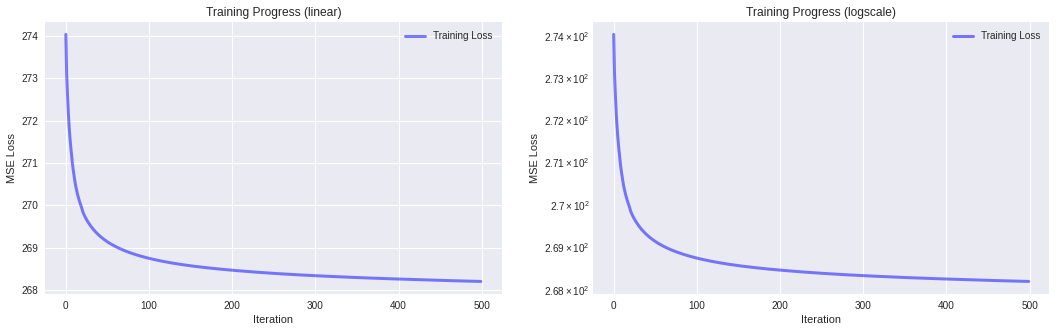

In [15]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 5)

ax[0].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("MSE Loss")
ax[0].set_title("Training Progress (linear)")

ax[1].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("MSE Loss")
ax[1].set_yscale("log")
ax[1].set_title("Training Progress (logscale)")
plt.show()

In [16]:
loss_list

[274.0356952855269,
 273.1015071964654,
 272.6066527358886,
 272.1865167962034,
 271.85031589515296,
 271.5830891090436,
 271.35816437843613,
 271.1642750435298,
 270.97144297440065,
 270.8159303081755,
 270.6841907353311,
 270.5541951840077,
 270.44190138416644,
 270.34736105960775,
 270.26365341990567,
 270.1884024118919,
 270.1201344857274,
 270.0575988901126,
 269.99981863093495,
 269.94434276855105,
 269.8711962222729,
 269.8164325157104,
 269.7720025670296,
 269.7311782198212,
 269.69328931722384,
 269.65777409466403,
 269.6242939309633,
 269.5926144775986,
 269.5625743769608,
 269.53394644367876,
 269.506575242659,
 269.4804475579089,
 269.4555398865587,
 269.43168808026434,
 269.4088023845669,
 269.3868280567556,
 269.3656794183261,
 269.3453079247109,
 269.3257251178995,
 269.30687436187986,
 269.28868342170557,
 269.27111124479444,
 269.2541259376062,
 269.23769183905733,
 269.2217885681928,
 269.2063982954309,
 269.19148315942147,
 269.1770182989892,
 269.1629889285133,
 269